# Reducing number of embeddings
---
As we look at the transaction data we can see that there are some very low cardinality features for which we use an embedding. In this notebook we will evaluate whether or not there is a difference in the model performance if we encoded them as `FeatureOneHot`

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import gc
import numpy as np
import pandas as pd
import math
import datetime as dt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
tr_train_file = '../../../../data/train_transaction.csv'
tr_test_file = '../../../../data/test_transaction.csv'
id_train_file = '../../../../data/train_identity.csv'
id_test_file = '../../../../data/train_identity.csv'

In [5]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def offset_to_datetime(offset: int):
    return dt.datetime(2017, 1, 11) + dt.timedelta(seconds=int(offset))

fraud     = ft.FeatureSource('isFraud', ft.FEATURE_TYPE_INT_8)
dtb       = ft.FeatureSource('TransactionDT', ft.FEATURE_TYPE_INT_32)
date_time = ft.FeatureExpression('date_time', ft.FEATURE_TYPE_DATE_TIME, offset_to_datetime, [dtb])

# Base Categorical features
amount  = ft.FeatureSource('TransactionAmt', ft.FEATURE_TYPE_FLOAT_32)
product = ft.FeatureSource('ProductCD', ft.FEATURE_TYPE_CATEGORICAL)
card1   = ft.FeatureSource('card1', ft.FEATURE_TYPE_CATEGORICAL)
card2   = ft.FeatureSource('card2', ft.FEATURE_TYPE_CATEGORICAL)
card3   = ft.FeatureSource('card3', ft.FEATURE_TYPE_CATEGORICAL)
card4   = ft.FeatureSource('card4', ft.FEATURE_TYPE_CATEGORICAL)
card5   = ft.FeatureSource('card5', ft.FEATURE_TYPE_CATEGORICAL)
card6   = ft.FeatureSource('card6', ft.FEATURE_TYPE_CATEGORICAL)
addr1   = ft.FeatureSource('addr1', ft.FEATURE_TYPE_CATEGORICAL)
addr2   = ft.FeatureSource('addr2', ft.FEATURE_TYPE_CATEGORICAL)
dist1   = ft.FeatureSource('dist1', ft.FEATURE_TYPE_FLOAT_32)
p_mail_dom = ft.FeatureSource('P_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)
r_mail_dom = ft.FeatureSource('R_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)

# Raw count features
c1  = ft.FeatureSource('C1', ft.FEATURE_TYPE_FLOAT_32)
c2  = ft.FeatureSource('C2', ft.FEATURE_TYPE_FLOAT_32)
c3  = ft.FeatureSource('C3', ft.FEATURE_TYPE_FLOAT_32)
c4  = ft.FeatureSource('C4', ft.FEATURE_TYPE_FLOAT_32)
c5  = ft.FeatureSource('C5', ft.FEATURE_TYPE_FLOAT_32)
c6  = ft.FeatureSource('C6', ft.FEATURE_TYPE_FLOAT_32)
c7  = ft.FeatureSource('C7', ft.FEATURE_TYPE_FLOAT_32)
c8  = ft.FeatureSource('C8', ft.FEATURE_TYPE_FLOAT_32)
c9  = ft.FeatureSource('C9', ft.FEATURE_TYPE_FLOAT_32)
c10 = ft.FeatureSource('C10', ft.FEATURE_TYPE_FLOAT_32)
c11 = ft.FeatureSource('C11', ft.FEATURE_TYPE_FLOAT_32)
c12 = ft.FeatureSource('C12', ft.FEATURE_TYPE_FLOAT_32)
c13 = ft.FeatureSource('C13', ft.FEATURE_TYPE_FLOAT_32)
c14 = ft.FeatureSource('C14', ft.FEATURE_TYPE_FLOAT_32)

# Raw distance features.
d1  = ft.FeatureSource('D1', ft.FEATURE_TYPE_FLOAT_32)
d2  = ft.FeatureSource('D2', ft.FEATURE_TYPE_FLOAT_32)
d3  = ft.FeatureSource('D3', ft.FEATURE_TYPE_FLOAT_32)
d4  = ft.FeatureSource('D4', ft.FEATURE_TYPE_FLOAT_32)
d5  = ft.FeatureSource('D5', ft.FEATURE_TYPE_FLOAT_32)
d6  = ft.FeatureSource('D6', ft.FEATURE_TYPE_FLOAT_32)
d7  = ft.FeatureSource('D7', ft.FEATURE_TYPE_FLOAT_32)
d8  = ft.FeatureSource('D8', ft.FEATURE_TYPE_FLOAT_32)
d9  = ft.FeatureSource('D9', ft.FEATURE_TYPE_FLOAT_32)
d10 = ft.FeatureSource('D10', ft.FEATURE_TYPE_FLOAT_32)
d11 = ft.FeatureSource('D11', ft.FEATURE_TYPE_FLOAT_32)
d12 = ft.FeatureSource('D12', ft.FEATURE_TYPE_FLOAT_32)
d13 = ft.FeatureSource('D13', ft.FEATURE_TYPE_FLOAT_32)
d14 = ft.FeatureSource('D14', ft.FEATURE_TYPE_FLOAT_32)
d15 = ft.FeatureSource('D15', ft.FEATURE_TYPE_FLOAT_32)

# Match features.
m1 = ft.FeatureSource('M1', ft.FEATURE_TYPE_CATEGORICAL)
m2 = ft.FeatureSource('M2', ft.FEATURE_TYPE_CATEGORICAL)
m3 = ft.FeatureSource('M3', ft.FEATURE_TYPE_CATEGORICAL)
m4 = ft.FeatureSource('M4', ft.FEATURE_TYPE_CATEGORICAL)
m5 = ft.FeatureSource('M5', ft.FEATURE_TYPE_CATEGORICAL)
m6 = ft.FeatureSource('M6', ft.FEATURE_TYPE_CATEGORICAL)
m7 = ft.FeatureSource('M7', ft.FEATURE_TYPE_CATEGORICAL)
m8 = ft.FeatureSource('M8', ft.FEATURE_TYPE_CATEGORICAL)
m9 = ft.FeatureSource('M9', ft.FEATURE_TYPE_CATEGORICAL)

td = ft.TensorDefinition('transactions', [
    date_time, amount, product, fraud, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, p_mail_dom,
    r_mail_dom, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, d1, d2, d3, d4, d5, d6, d7, d8, d9,
    d10, d11, d12, d13, d14, d15, m1, m2, m3, m4, m5, m6, m7, m8, m9
])

with en.EnginePandas(num_threads=1) as e:
    df = e.df_from_csv(td, tr_train_file, inference=False)

2023-06-01 11:29:30.136 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 11:29:30.137 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 11:29:30.137 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 11:29:30.138 eng1n3.pandas.pandasengine     INFO     Building Panda for : transactions from file ../../../../data/train_transaction.csv
2023-06-01 11:29:34.337 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: transactions


## Match Features

The match feature are the features with very low cardinality. Most have only 2 unique values. We'll start by encoding them as `FeatureOneHot`

In [6]:
df[[f'M{i}' for i in range(1,10)]].describe()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,2,2,2,3,2,2,2,2,2
top,T,T,T,M0,F,F,F,F,T
freq,319415,285468,251731,196405,132491,227856,211374,155251,205656


### Define Features

In [7]:
# Categorical features.
amount_bin  = ft.FeatureBin('Amount_Bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
dist_bin    = ft.FeatureBin('Dist_Bin', ft.FEATURE_TYPE_INT_8, dist1, 20, scale_type='geometric')
dow         = ft.FeatureDateTimeFormat('day_of_week', ft.FEATURE_TYPE_INT_8, date_time, '%w')
dom         = ft.FeatureDateTimeFormat('day_of_month', ft.FEATURE_TYPE_INT_16, date_time, '%d')
hod         = ft.FeatureDateTimeFormat('hour_of_day', ft.FEATURE_TYPE_INT_16, date_time, '%H')
dow_i       = ft.FeatureIndex('day_of_week_i', ft.FEATURE_TYPE_INT_16, dow)
dom_i       = ft.FeatureIndex('day_of_month_i', ft.FEATURE_TYPE_INT_16, dom)
hod_i       = ft.FeatureIndex('hour_of_day_i', ft.FEATURE_TYPE_INT_16, hod)
product_i   = ft.FeatureIndex('product_i', ft.FEATURE_TYPE_INT_16, product)
card2_i     = ft.FeatureIndex('card2_i', ft.FEATURE_TYPE_INT_16, card2)
card3_i     = ft.FeatureIndex('card3_i', ft.FEATURE_TYPE_INT_16, card3)
card4_i     = ft.FeatureIndex('card4_i', ft.FEATURE_TYPE_INT_16, card4)
card5_i     = ft.FeatureIndex('card5_i', ft.FEATURE_TYPE_INT_16, card5)
card6_i     = ft.FeatureIndex('card6_i', ft.FEATURE_TYPE_INT_16, card6)
addr1_i     = ft.FeatureIndex('addr1_i', ft.FEATURE_TYPE_INT_16, addr1)
addr2_i     = ft.FeatureIndex('addr2_i', ft.FEATURE_TYPE_INT_16, addr2)
p_mail_dom_i = ft.FeatureIndex('P_emaildomain_i', ft.FEATURE_TYPE_INT_16, p_mail_dom)
r_mail_dom_i = ft.FeatureIndex('R_emaildomain_i', ft.FEATURE_TYPE_INT_16, r_mail_dom)

# Count Features
c1_bin     = ft.FeatureBin('C1_Bin', ft.FEATURE_TYPE_INT_8, c1, 20, scale_type='geometric')
c2_bin     = ft.FeatureBin('C2_Bin', ft.FEATURE_TYPE_INT_8, c2, 20, scale_type='geometric')
c4_bin     = ft.FeatureBin('C4_Bin', ft.FEATURE_TYPE_INT_8, c4, 20, scale_type='geometric')
c5_bin     = ft.FeatureBin('C5_Bin', ft.FEATURE_TYPE_INT_8, c5, 20, scale_type='geometric')
c6_bin     = ft.FeatureBin('C6_Bin', ft.FEATURE_TYPE_INT_8, c6, 20, scale_type='geometric')
c7_bin     = ft.FeatureBin('C7_Bin', ft.FEATURE_TYPE_INT_8, c7, 20, scale_type='geometric')
c8_bin     = ft.FeatureBin('C8_Bin', ft.FEATURE_TYPE_INT_8, c8, 20, scale_type='geometric')
c9_bin     = ft.FeatureBin('C9_Bin', ft.FEATURE_TYPE_INT_8, c9, 20, scale_type='geometric')
c10_bin    = ft.FeatureBin('C10_Bin', ft.FEATURE_TYPE_INT_8, c10, 20, scale_type='geometric')
c11_bin    = ft.FeatureBin('C11_Bin', ft.FEATURE_TYPE_INT_8, c11, 20, scale_type='geometric')
c12_bin    = ft.FeatureBin('C12_Bin', ft.FEATURE_TYPE_INT_8, c12, 20, scale_type='geometric')
c13_bin    = ft.FeatureBin('C13_Bin', ft.FEATURE_TYPE_INT_8, c13, 20, scale_type='geometric')
c14_bin    = ft.FeatureBin('C14_Bin', ft.FEATURE_TYPE_INT_8, c14, 20, scale_type='geometric')


# Function to replace a negative number with Nan. For use as FeatureExpression.
def set_negative_to_nan(feature: int):
    return feature if not math.isnan(feature) and feature >= 0 else np.nan

# Timing Features
d1_bin  = ft.FeatureBin('D1_Bin', ft.FEATURE_TYPE_INT_8, d1, 15)
d2_bin  = ft.FeatureBin('D2_Bin', ft.FEATURE_TYPE_INT_8, d2, 15)
d3_bin  = ft.FeatureBin('D3_Bin', ft.FEATURE_TYPE_INT_8, d3, 15)
d4_bin  = ft.FeatureBin('D4_Bin', ft.FEATURE_TYPE_INT_8, d4, 15)
d5_bin  = ft.FeatureBin('D5_Bin', ft.FEATURE_TYPE_INT_8, d5, 15)
d6_ex   = ft.FeatureExpression('d6_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d6])
d6_bin  = ft.FeatureBin('D6_Bin', ft.FEATURE_TYPE_INT_8, d6_ex, 15)
d7_bin  = ft.FeatureBin('D7_Bin', ft.FEATURE_TYPE_INT_8, d7, 15)
d8_bin  = ft.FeatureBin('D8_Bin', ft.FEATURE_TYPE_INT_8, d8, 15)
d9_bin  = ft.FeatureBin('D9_Bin', ft.FEATURE_TYPE_INT_8, d9, 15)
d10_bin = ft.FeatureBin('D10_Bin', ft.FEATURE_TYPE_INT_8, d10, 15)
d11_ex  = ft.FeatureExpression('d11_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d11])
d11_bin = ft.FeatureBin('D11_Bin', ft.FEATURE_TYPE_INT_8, d11_ex, 15)
d12_ex  = ft.FeatureExpression('d12_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d12])
d12_bin = ft.FeatureBin('D12_Bin', ft.FEATURE_TYPE_INT_8, d12_ex, 15)
d13_bin = ft.FeatureBin('D13_Bin', ft.FEATURE_TYPE_INT_8, d13, 15)
d14_ex  = ft.FeatureExpression('d14_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d14])
d14_bin = ft.FeatureBin('D14_Bin', ft.FEATURE_TYPE_INT_8, d14_ex, 15)
d15_ex  = ft.FeatureExpression('d15_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d15])
d15_bin = ft.FeatureBin('D15_Bin', ft.FEATURE_TYPE_INT_8, d15_ex, 15)

# Match features, this time as one-hot
m1_oh = ft.FeatureOneHot('m1_oh', ft.FEATURE_TYPE_INT_8, m1)
m2_oh = ft.FeatureOneHot('m2_oh', ft.FEATURE_TYPE_INT_8, m2)
m3_oh = ft.FeatureOneHot('m3_oh', ft.FEATURE_TYPE_INT_8, m3)
m4_oh = ft.FeatureOneHot('m4_oh', ft.FEATURE_TYPE_INT_8, m4)
m5_oh = ft.FeatureOneHot('m5_oh', ft.FEATURE_TYPE_INT_8, m5)
m6_oh = ft.FeatureOneHot('m6_oh', ft.FEATURE_TYPE_INT_8, m6)
m7_oh = ft.FeatureOneHot('m7_oh', ft.FEATURE_TYPE_INT_8, m7)
m8_oh = ft.FeatureOneHot('m8_oh', ft.FEATURE_TYPE_INT_8, m8)
m9_oh = ft.FeatureOneHot('m9_oh', ft.FEATURE_TYPE_INT_8, m9)

# Label Feature
fraud_label = ft.FeatureLabelBinary('Fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

# TensorDefinitions
td_categorical = ft.TensorDefinition('ieee-categorical', [
    amount_bin, dist_bin, dow_i, hod_i, product_i, card2_i, card3_i, card4_i, card5_i, card6_i, addr1_i, 
    p_mail_dom_i, r_mail_dom_i
])

td_counts = ft.TensorDefinition('ieee-counts', [
    c1_bin, c2_bin, c4_bin, c5_bin, c6_bin, c7_bin, c8_bin, c9_bin, c10_bin, 
    c11_bin, c12_bin, c13_bin, c14_bin
])

td_timing = ft.TensorDefinition('ieee-timing', [
    d1_bin, d2_bin, d3_bin, d4_bin, d5_bin, d6_bin, d7_bin, d8_bin, d9_bin, d10_bin, 
    d11_bin, d12_bin, d13_bin, d14_bin, d15_bin
])


td_match = ft.TensorDefinition('ieee-match', [m1_oh, m2_oh, m3_oh, m4_oh, m5_oh, m6_oh, m7_oh, m8_oh, m9_oh])

td_label = ft.TensorDefinition('ieee-label', [fraud_label])

### Setup Datasets and Loaders

In [8]:
with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv(
        (td_categorical, td_counts, td_timing, td_match, td_label), 
        tr_train_file, inference=False
    )

train, val, test = ti.split_sequential(50000,0)

train_sampler = mp.TensorInstanceNumpyLabelSampler().over_sampler(train)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

train_dl = train_ds.data_loader(torch.device('cpu'), 128, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(torch.device('cpu'), 128, num_workers=2)

mc = mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def)

2023-06-01 11:29:42.742 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 11:29:42.742 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 11:29:42.742 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 11:29:42.743 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv
2023-06-01 11:29:50.658 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 11:29:50.671 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 5 numpy arrays


### Define Model

In [9]:
class IEEEFeedForwardModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(IEEEFeedForwardModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(max_dims=30)
        heads_size = sum([h.output_size for h in self.heads])
        
        # Set of layers
        self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=(128,64,64,32), dropout=0.0, bn_interval=2)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a 'IEEEFeedForwardModel' instance
model = IEEEFeedForwardModel(mc)
model

IEEEFeedForwardModel(
  Number of parameters : 118642. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=ieee-categorical, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(20, 10)
          (2): Embedding(8, 5)
          (3): Embedding(25, 12)
          (4): Embedding(6, 5)
          (5): Embedding(501, 30)
          (6): Embedding(115, 30)
          (7): Embedding(5, 5)
          (8): Embedding(120, 30)
          (9): Embedding(5, 5)
          (10): Embedding(333, 30)
          (11): Embedding(60, 30)
          (12): Embedding(61, 30)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(
      Name=ieee-counts, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0-12): 13 x Embedding(20, 10)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
 

### Train 

In [10]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)

# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=3e-3)

# Set-up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 4614/4614 [00:15<00:00, 289.28it/s, t_loss=0.0942, t_acc=0.963, v_loss=0.211, v_acc=0.935]     


### Test
After testing we can pretty much see that there is no change in the model performance, so for this architecture we are **good to replace the match features** with OneHot encodings.

Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 567.10it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     48104
         1.0       0.32      0.63      0.42      1896

    accuracy                           0.93     50000
   macro avg       0.65      0.79      0.69     50000
weighted avg       0.96      0.93      0.94     50000


auc score : 0.8929
ap score  : 0.4687
-----------------------------------------------------


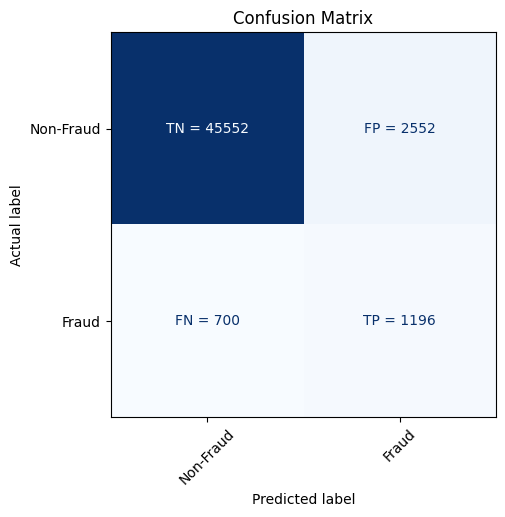

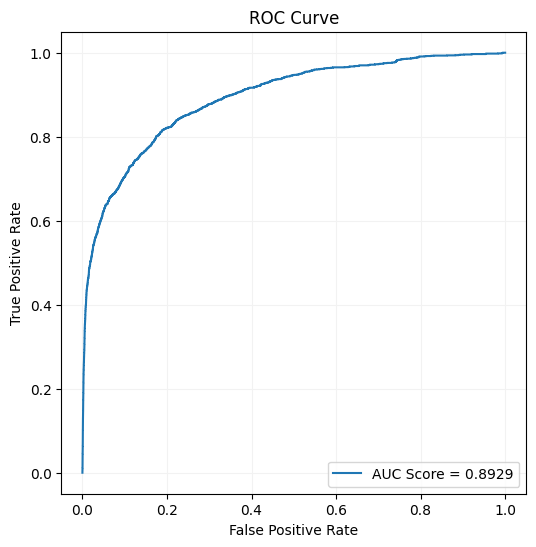

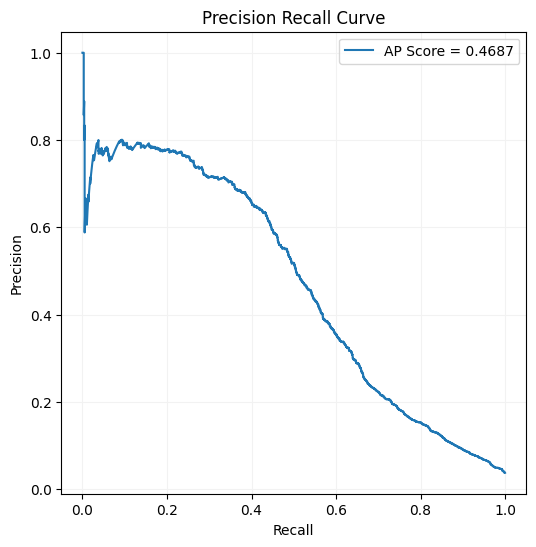

In [11]:
t = mp.Tester(model, torch.device(model_device), val_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

### Other Low Cardinality Features

In the base feature set, we have some other features with fairly low cardinality. We're going to replace any features with a cardinality lower than or equal to 5 by a `FeatureOneHot`

In [12]:
df[
    ['ProductCD'] + [f'card{i}' for i in range (1,7)] + ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']
].describe()

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain
count,590540,590540,581607,588975,588963,586281,588969,524834,524834,496084,137291
unique,5,13553,500,114,4,119,4,332,74,59,60
top,W,7919,321.0,150.0,visa,226.0,debit,299.0,87.0,gmail.com,gmail.com
freq,439670,14932,48935,521287,384767,296546,439938,46335,520481,228355,57147


### Define Features

In [13]:
# Categorical features.
amount_bin  = ft.FeatureBin('Amount_Bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
dist_bin    = ft.FeatureBin('Dist_Bin', ft.FEATURE_TYPE_INT_8, dist1, 20, scale_type='geometric')
dow         = ft.FeatureDateTimeFormat('day_of_week', ft.FEATURE_TYPE_INT_8, date_time, '%w')
dom         = ft.FeatureDateTimeFormat('day_of_month', ft.FEATURE_TYPE_INT_16, date_time, '%d')
hod         = ft.FeatureDateTimeFormat('hour_of_day', ft.FEATURE_TYPE_INT_16, date_time, '%H')
dow_i       = ft.FeatureIndex('day_of_week_i', ft.FEATURE_TYPE_INT_16, dow)
dom_i       = ft.FeatureIndex('day_of_month_i', ft.FEATURE_TYPE_INT_16, dom)
hod_i       = ft.FeatureIndex('hour_of_day_i', ft.FEATURE_TYPE_INT_16, hod)
card2_i     = ft.FeatureIndex('card2_i', ft.FEATURE_TYPE_INT_16, card2)
card3_i     = ft.FeatureIndex('card3_i', ft.FEATURE_TYPE_INT_16, card3)
card5_i     = ft.FeatureIndex('card5_i', ft.FEATURE_TYPE_INT_16, card5)
addr1_i     = ft.FeatureIndex('addr1_i', ft.FEATURE_TYPE_INT_16, addr1)
addr2_i     = ft.FeatureIndex('addr2_i', ft.FEATURE_TYPE_INT_16, addr2)
p_mail_dom_i = ft.FeatureIndex('P_emaildomain_i', ft.FEATURE_TYPE_INT_16, p_mail_dom)
r_mail_dom_i = ft.FeatureIndex('R_emaildomain_i', ft.FEATURE_TYPE_INT_16, r_mail_dom)

# Binary Features
product_oh  = ft.FeatureOneHot('product_oh', ft.FEATURE_TYPE_INT_8, product)
card4_oh    = ft.FeatureOneHot('card4_oh', ft.FEATURE_TYPE_INT_8, card4)
card6_oh    = ft.FeatureOneHot('card6_oh', ft.FEATURE_TYPE_INT_8, card6)
m1_oh       = ft.FeatureOneHot('m1_oh', ft.FEATURE_TYPE_INT_8, m1)
m2_oh       = ft.FeatureOneHot('m2_oh', ft.FEATURE_TYPE_INT_8, m2)
m3_oh       = ft.FeatureOneHot('m3_oh', ft.FEATURE_TYPE_INT_8, m3)
m4_oh       = ft.FeatureOneHot('m4_oh', ft.FEATURE_TYPE_INT_8, m4)
m5_oh       = ft.FeatureOneHot('m5_oh', ft.FEATURE_TYPE_INT_8, m5)
m6_oh       = ft.FeatureOneHot('m6_oh', ft.FEATURE_TYPE_INT_8, m6)
m7_oh       = ft.FeatureOneHot('m7_oh', ft.FEATURE_TYPE_INT_8, m7)
m8_oh       = ft.FeatureOneHot('m8_oh', ft.FEATURE_TYPE_INT_8, m8)
m9_oh       = ft.FeatureOneHot('m9_oh', ft.FEATURE_TYPE_INT_8, m9)

# Count Features
c1_bin     = ft.FeatureBin('C1_Bin', ft.FEATURE_TYPE_INT_8, c1, 20, scale_type='geometric')
c2_bin     = ft.FeatureBin('C2_Bin', ft.FEATURE_TYPE_INT_8, c2, 20, scale_type='geometric')
c4_bin     = ft.FeatureBin('C4_Bin', ft.FEATURE_TYPE_INT_8, c4, 20, scale_type='geometric')
c5_bin     = ft.FeatureBin('C5_Bin', ft.FEATURE_TYPE_INT_8, c5, 20, scale_type='geometric')
c6_bin     = ft.FeatureBin('C6_Bin', ft.FEATURE_TYPE_INT_8, c6, 20, scale_type='geometric')
c7_bin     = ft.FeatureBin('C7_Bin', ft.FEATURE_TYPE_INT_8, c7, 20, scale_type='geometric')
c8_bin     = ft.FeatureBin('C8_Bin', ft.FEATURE_TYPE_INT_8, c8, 20, scale_type='geometric')
c9_bin     = ft.FeatureBin('C9_Bin', ft.FEATURE_TYPE_INT_8, c9, 20, scale_type='geometric')
c10_bin    = ft.FeatureBin('C10_Bin', ft.FEATURE_TYPE_INT_8, c10, 20, scale_type='geometric')
c11_bin    = ft.FeatureBin('C11_Bin', ft.FEATURE_TYPE_INT_8, c11, 20, scale_type='geometric')
c12_bin    = ft.FeatureBin('C12_Bin', ft.FEATURE_TYPE_INT_8, c12, 20, scale_type='geometric')
c13_bin    = ft.FeatureBin('C13_Bin', ft.FEATURE_TYPE_INT_8, c13, 20, scale_type='geometric')
c14_bin    = ft.FeatureBin('C14_Bin', ft.FEATURE_TYPE_INT_8, c14, 20, scale_type='geometric')


# Function to replace a negative number with Nan. For use as FeatureExpression.
def set_negative_to_nan(feature: int):
    return feature if not math.isnan(feature) and feature >= 0 else np.nan

# Timing Features
d1_bin  = ft.FeatureBin('D1_Bin', ft.FEATURE_TYPE_INT_8, d1, 15)
d2_bin  = ft.FeatureBin('D2_Bin', ft.FEATURE_TYPE_INT_8, d2, 15)
d3_bin  = ft.FeatureBin('D3_Bin', ft.FEATURE_TYPE_INT_8, d3, 15)
d4_bin  = ft.FeatureBin('D4_Bin', ft.FEATURE_TYPE_INT_8, d4, 15)
d5_bin  = ft.FeatureBin('D5_Bin', ft.FEATURE_TYPE_INT_8, d5, 15)
d6_ex   = ft.FeatureExpression('d6_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d6])
d6_bin  = ft.FeatureBin('D6_Bin', ft.FEATURE_TYPE_INT_8, d6_ex, 15)
d7_bin  = ft.FeatureBin('D7_Bin', ft.FEATURE_TYPE_INT_8, d7, 15)
d8_bin  = ft.FeatureBin('D8_Bin', ft.FEATURE_TYPE_INT_8, d8, 15)
d9_bin  = ft.FeatureBin('D9_Bin', ft.FEATURE_TYPE_INT_8, d9, 15)
d10_bin = ft.FeatureBin('D10_Bin', ft.FEATURE_TYPE_INT_8, d10, 15)
d11_ex  = ft.FeatureExpression('d11_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d11])
d11_bin = ft.FeatureBin('D11_Bin', ft.FEATURE_TYPE_INT_8, d11_ex, 15)
d12_ex  = ft.FeatureExpression('d12_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d12])
d12_bin = ft.FeatureBin('D12_Bin', ft.FEATURE_TYPE_INT_8, d12_ex, 15)
d13_bin = ft.FeatureBin('D13_Bin', ft.FEATURE_TYPE_INT_8, d13, 15)
d14_ex  = ft.FeatureExpression('d14_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d14])
d14_bin = ft.FeatureBin('D14_Bin', ft.FEATURE_TYPE_INT_8, d14_ex, 15)
d15_ex  = ft.FeatureExpression('d15_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d15])
d15_bin = ft.FeatureBin('D15_Bin', ft.FEATURE_TYPE_INT_8, d15_ex, 15)

# Label Feature
fraud_label = ft.FeatureLabelBinary('Fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

# TensorDefinitions
td_categorical = ft.TensorDefinition('ieee-categorical', [
    amount_bin, dist_bin, dow_i, hod_i, card2_i, card3_i, card5_i, addr1_i, p_mail_dom_i, r_mail_dom_i
])

td_counts = ft.TensorDefinition('ieee-counts', [
    c1_bin, c2_bin, c4_bin, c5_bin, c6_bin, c7_bin, c8_bin, c9_bin, c10_bin, 
    c11_bin, c12_bin, c13_bin, c14_bin
])

td_timing = ft.TensorDefinition('ieee-timing', [
    d1_bin, d2_bin, d3_bin, d4_bin, d5_bin, d6_bin, d7_bin, d8_bin, d9_bin, d10_bin, 
    d11_bin, d12_bin, d13_bin, d14_bin, d15_bin
])

td_binary = ft.TensorDefinition('ieee-binary', [
    product_oh, card4_oh, card6_oh, m1_oh, m2_oh, m3_oh, m4_oh, m5_oh, m6_oh, m7_oh, m8_oh, m9_oh])

td_label = ft.TensorDefinition('ieee-label', [fraud_label])

### Define Datasets and Loaders

In [14]:
with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv(
        (td_categorical, td_counts, td_timing, td_binary, td_label), 
        tr_train_file, inference=False
    )

train, val, test = ti.split_sequential(50000,0)

train_sampler = mp.TensorInstanceNumpyLabelSampler().over_sampler(train)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

train_dl = train_ds.data_loader(torch.device('cpu'), 128, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(torch.device('cpu'), 128, num_workers=2)

mc = mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def)

2023-06-01 11:32:08.092 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 11:32:08.093 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 11:32:08.093 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 11:32:08.095 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv
2023-06-01 11:32:15.998 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 11:32:16.010 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 5 numpy arrays


### Define Model

In [15]:
class IEEEFeedForwardModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(IEEEFeedForwardModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(max_dims=30)
        heads_size = sum([h.output_size for h in self.heads])
        
        # Set of layers
        self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=(128,64,64,32), dropout=0.0, bn_interval=2)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a 'IEEEFeedForwardModel' instance
model = IEEEFeedForwardModel(mc)
model

IEEEFeedForwardModel(
  Number of parameters : 118306. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=ieee-categorical, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(20, 10)
          (2): Embedding(8, 5)
          (3): Embedding(25, 12)
          (4): Embedding(501, 30)
          (5): Embedding(115, 30)
          (6): Embedding(120, 30)
          (7): Embedding(333, 30)
          (8): Embedding(60, 30)
          (9): Embedding(61, 30)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(
      Name=ieee-counts, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0-12): 13 x Embedding(20, 10)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (2): TensorDefinitionHead(
      Name=ieee-timing, lc=Categorical
      (embedding): Embeddin

### Train

In [16]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)

# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=3e-3)

# Set-up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 4614/4614 [00:17<00:00, 263.70it/s, t_loss=0.0946, t_acc=0.963, v_loss=0.21, v_acc=0.938]      


### Test
This is not so successful, the model clearly took a performance hit. With this architecture it is clear that embeddings work better.

Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 620.78it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     48104
         1.0       0.33      0.62      0.43      1896

    accuracy                           0.94     50000
   macro avg       0.66      0.78      0.70     50000
weighted avg       0.96      0.94      0.95     50000


auc score : 0.8848
ap score  : 0.4906
-----------------------------------------------------


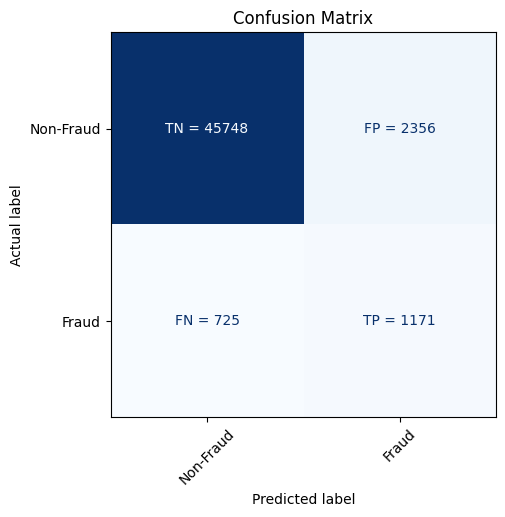

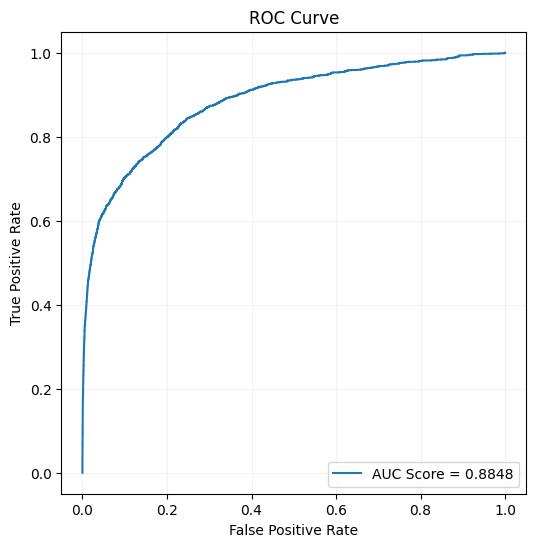

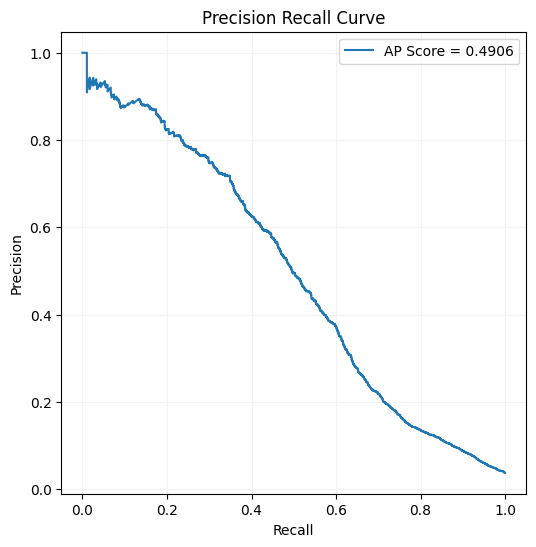

In [17]:
t = mp.Tester(model, torch.device(model_device), val_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

In [19]:
attr = cp.CaptumAttributions.get_attributions_binary(
    model, ti.target_tensor_def, model_device, IntegratedGradients, val_ds[:10000]
    #model, ti.target_tensor_def, model_device, IntegratedGradients, val_ds[10000:20000]
)

/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


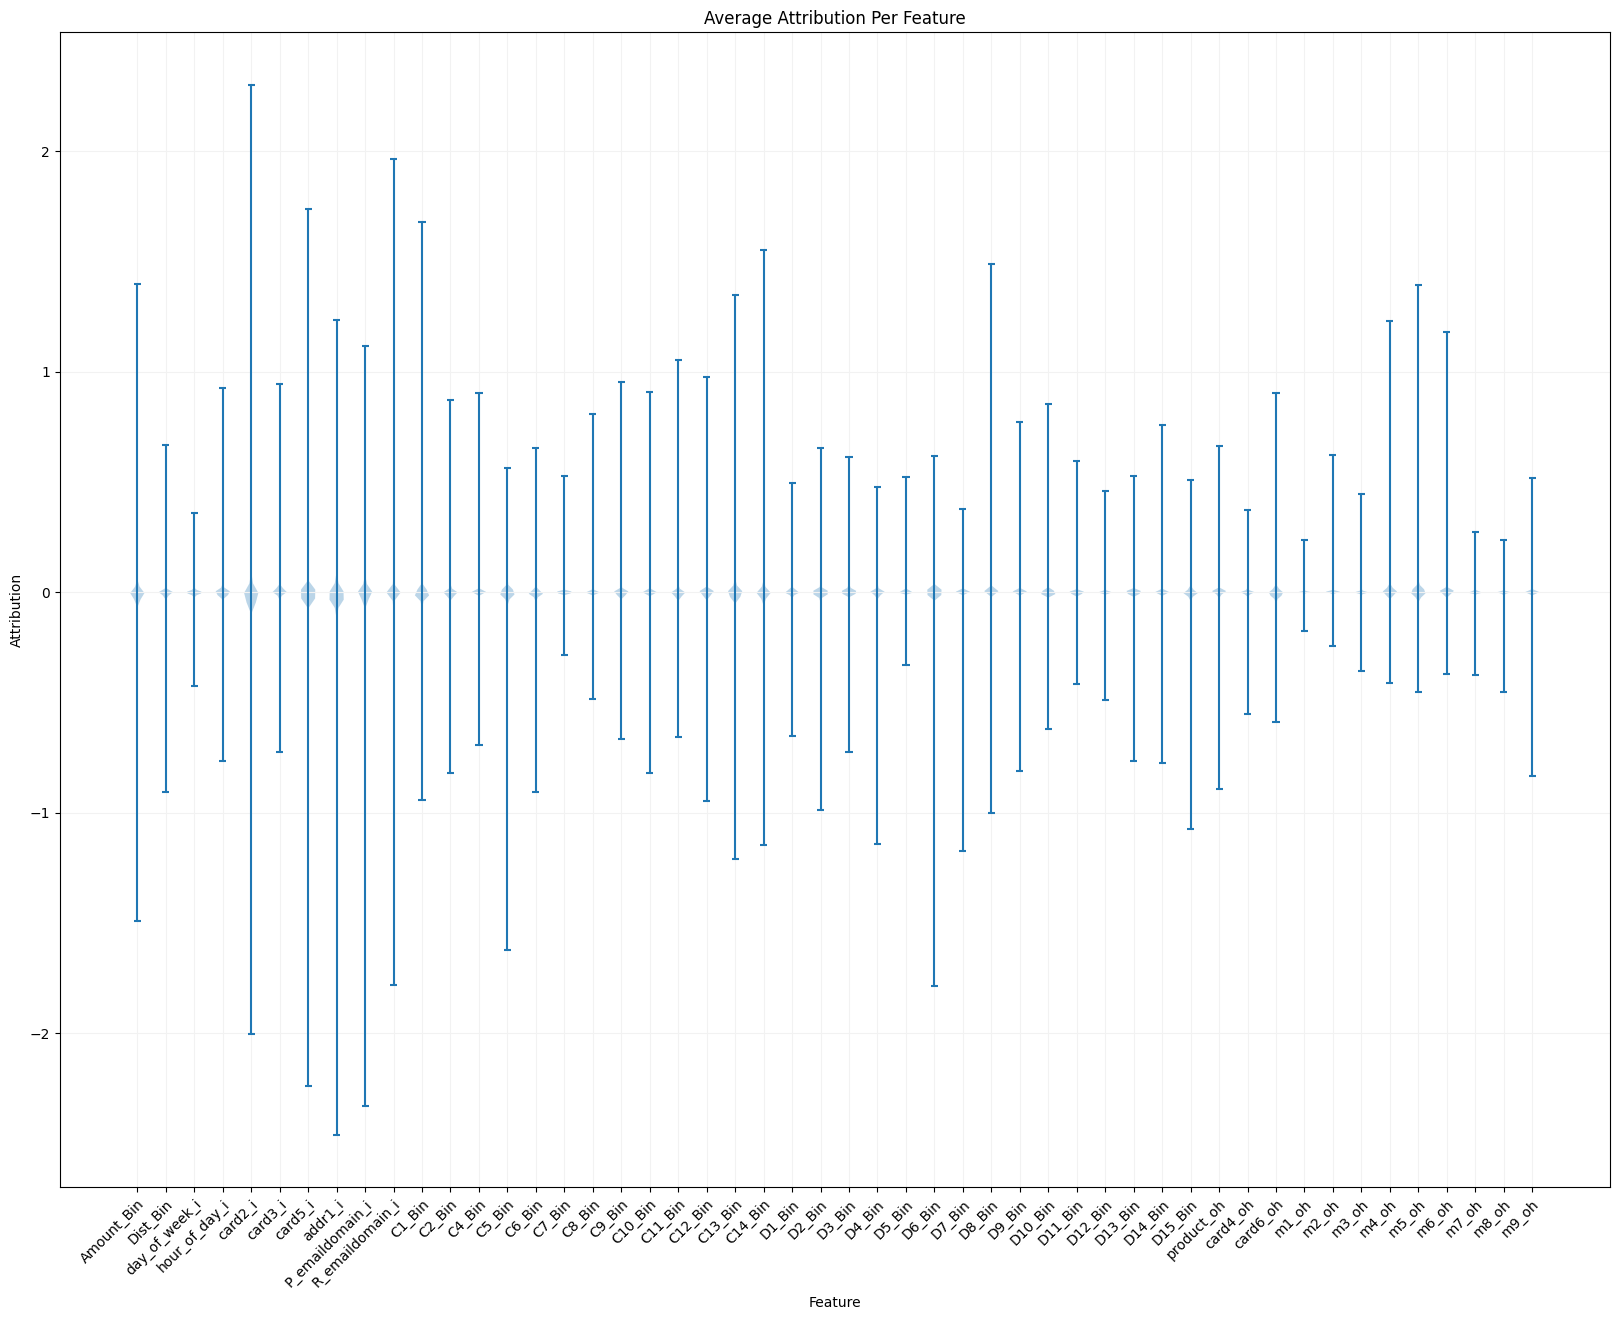

In [20]:
mplt.AttributionPlotBinary.overview(attr, fig_size=(20,15))

# Conclusion
With these tests it became clear that we can replace really low cardinality features (more or less flags) with a `FeatureOneHot` without harming the model. This does not seem to hold for feature that have slightly higher cardinality (like the product code for instance). 

Quite interesting, it seems that the embeddings might actually provide a useful abstraction in the models.